In [1]:
# Importación de las librerías
import numpy as np
import pandas as pd
from keras.models import load_model
import modulo_conn_sql as mcq
import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from io import BytesIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pickle import dump, load

#Metodos auxiliares
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

In [6]:
#Variables del Forecast

#mermoria corto plazo
timesteps = 20
#numero de neuronas
un = 180
#coeficiente de olvido
do = 0.1
#activar o desactivar dropout
flag_do = True
#numero de ciclos
ep = 400
#numero de capas ocultas
ly = 3

#pais
pais='Colombia'

#cliente target
cliente = '50119577'
obra = '66883698'

fecha_inicio_forecast = '2021-08-01'
fecha_fin_forecast = '2021-08-31'

#Dataset de los despachos
df = querySQL("{CALL SCAC_AP10_dataset_servicios (?,?)}" , (pais, (timesteps*2))) #traigo el doble de los timesteps para asegurarme de tener suficientes datos para prediccion
df = df.fillna(value=np.nan)
df['year_month'] = df.FechaEntrega.dt.to_period('M')

In [15]:
#Dataset con el despacho diario del cliente target
dataset = df[df['Obra'] == obra].groupby(['FechaEntrega']).agg({'VolPartida': sum}).reset_index()
dataset['FechaEntrega'] = pd.to_datetime(dataset['FechaEntrega'])      

#Variables auxiliares
df_calendario_prediccion = querySQL( "select * from SCAC_AT3_DiasHabilesFuente where pais = (?)" , (pais) )
df_calendario_prediccion['Fecha de entrega'] = pd.to_datetime(df_calendario_prediccion['Fecha de entrega'])
df_calendario_prediccion = df_calendario_prediccion[(df_calendario_prediccion['Fecha de entrega'] >= dataset['FechaEntrega'].min() ) & (df_calendario_prediccion['Fecha de entrega'] <= fecha_fin_forecast) & (df_calendario_prediccion['Días_Operativos'] == 1)]

#hago un join de la variable principal y la auxiliares para el dataset inicial
dataset = pd.merge(df_calendario_prediccion, dataset, left_on='Fecha de entrega', right_on= 'FechaEntrega', how = 'inner').fillna(0)
dataset = dataset[['Fecha de entrega','VolPartida', 'Dia_Semana', 'Semana_relativa', 'Semanas_mes', 'Mes', 'Año']]
dataset.rename(columns = {'Fecha de entrega' : 'FechaEntrega'}, inplace = True)
dataset = dataset[dataset['FechaEntrega'] < fecha_inicio_forecast]
dataset_array = dataset.iloc[:, 1:7].values

#cargo el mejor regressor
regressor = load_model('../datos/regresor_'+ obra + '.h5')
#cargo el escalador
sc = load(open("../datos/escalador_" + obra + ".kpl", "rb"))
              
#tomo unicamente las variables de interes
#el doble Dia_Semana no es un error, la primera columna es dummy ya que el escalador espera recibir un determinado numero de columnas
df_aux_var = df_calendario_prediccion[df_calendario_prediccion['Fecha de entrega'] >= fecha_inicio_forecast]
df_aux_var = df_aux_var[['Dia_Semana','Dia_Semana', 'Semana_relativa', 'Semanas_mes', 'Mes', 'Año']]

In [17]:
#convierto en array el dataset a predecir y escalo las variables
predict_set = df_aux_var.iloc[:,0:7]
predict_set_scaled = sc.transform(predict_set)
               
#escalado de caracteristicas del dataset inicial
test_set_scaled = sc.transform(dataset_array)
              
#inputs van a ser los ultimo Timesteps dias del dataset inicial, para iniciar la prediccion
inputs = test_set_scaled[len(test_set_scaled) - timesteps:]

#Inicia prediccion
for j in range (0, predict_set_scaled.shape[0] ):
    
    X_test = []
    X_test_material = []
    X_test_DiaSemana = []
    X_test_SemanaRelativa = []
    X_test_SemanaMes = []
    X_test_Mes = []
    X_test_Year = []

    for i in range(timesteps, inputs.shape[0]+1 ):
        #columna 0 -> Cantidad Material
        X_test_material.append( inputs[i-timesteps:i, 0])

        #columna 1 -> DiaSemana
        X_test_DiaSemana.append( inputs[i-timesteps:i, 1])

        #columna 2 -> Mes
        X_test_Mes.append( inputs[i-timesteps:i, 2])        

        #columna 3 -> SemanaRelativa
        X_test_SemanaRelativa.append( inputs[i-timesteps:i, 3])

        #columna 4 -> SemanaMes
        X_test_SemanaMes.append( inputs[i-timesteps:i, 4])

        #columna 5 -> Year
        X_test_Year.append( inputs[i-timesteps:i, 5])


    #se convierten los array en objetos numpy    
    X_test_material = np.array( X_test_material)
    X_test_DiaSemana =  np.array(X_test_DiaSemana )
    X_test_SemanaRelativa = np.array( X_test_SemanaRelativa)
    X_test_SemanaMes = np.array(X_test_SemanaMes )
    X_test_Mes = np.array(X_test_Mes )
    X_test_Year = np.array( X_test_Year)

    #Se agrega una nueva dimension a las variables
    X_test_material = np.reshape(X_test_material, (X_test_material.shape[0], X_test_material.shape[1], 1 ))
    X_test_DiaSemana = np.reshape(X_test_DiaSemana, (X_test_DiaSemana.shape[0], X_test_DiaSemana.shape[1], 1 ))
    X_test_SemanaRelativa = np.reshape(X_test_SemanaRelativa, (X_test_SemanaRelativa.shape[0], X_test_SemanaRelativa.shape[1], 1 ))
    X_test_SemanaMes = np.reshape(X_test_SemanaMes, (X_test_SemanaMes.shape[0], X_test_SemanaMes.shape[1], 1 ))
    X_test_Mes = np.reshape(X_test_Mes, (X_test_Mes.shape[0], X_test_Mes.shape[1], 1 ))
    X_test_Year = np.reshape(X_test_Year, (X_test_Year.shape[0], X_test_Year.shape[1], 1 ))

    #se crea el la estructura de datos que se le va a pasar al regresor
    X_test = np.append(X_test_material, (X_test_DiaSemana), axis = 2 )
    X_test = np.append(X_test, (X_test_Mes), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaRelativa), axis = 2 )
    X_test = np.append(X_test, (X_test_SemanaMes), axis = 2 )
    X_test = np.append(X_test, (X_test_Year), axis = 2 )

    # por fin, ejecutar prediccion
    prediction = regressor.predict(X_test)

    #a la prediccion le agrego las demas variables predictoras
    prediction = np.append(prediction, (predict_set_scaled[:len(prediction), 1 : ]), axis=1 )

    inputs = test_set_scaled[len(test_set_scaled) - timesteps:]

    inputs = np.append(inputs, (prediction), axis=0 )

prediction = sc.inverse_transform(prediction)

df_result = pd.DataFrame({'Forecast': prediction[:, 0]})
df_result_complemento = df_calendario_prediccion[df_calendario_prediccion['Fecha de entrega'] >= fecha_inicio_forecast ]
df_result_complemento = df_result_complemento.reset_index()
df_result_complemento = df_result_complemento[['Fecha de entrega','Dia_Semana', 'Semana_relativa', 'Semanas_mes', 'Mes', 'Año']]
df_result_complemento.rename(columns = {'Fecha de entrega' : 'FechaEntrega'}, inplace = True)

df_result = pd.concat([df_result_complemento, df_result], axis = 1)

In [18]:
df_result

,FechaEntrega,Dia_Semana,Semana_relativa,Semanas_mes,Mes,Año,Forecast
0,2021-08-02,2,1,32,8,2021,152.195043
1,2021-08-03,3,1,32,8,2021,124.926502
2,2021-08-04,4,1,32,8,2021,77.723017
3,2021-08-05,5,1,32,8,2021,39.227086
4,2021-08-06,6,1,32,8,2021,51.829283
5,2021-08-09,2,2,33,8,2021,81.352768
6,2021-08-10,3,2,33,8,2021,96.428248
7,2021-08-11,4,2,33,8,2021,75.081190
8,2021-08-12,5,2,33,8,2021,35.217328
9,2021-08-13,6,2,33,8,2021,13.917975


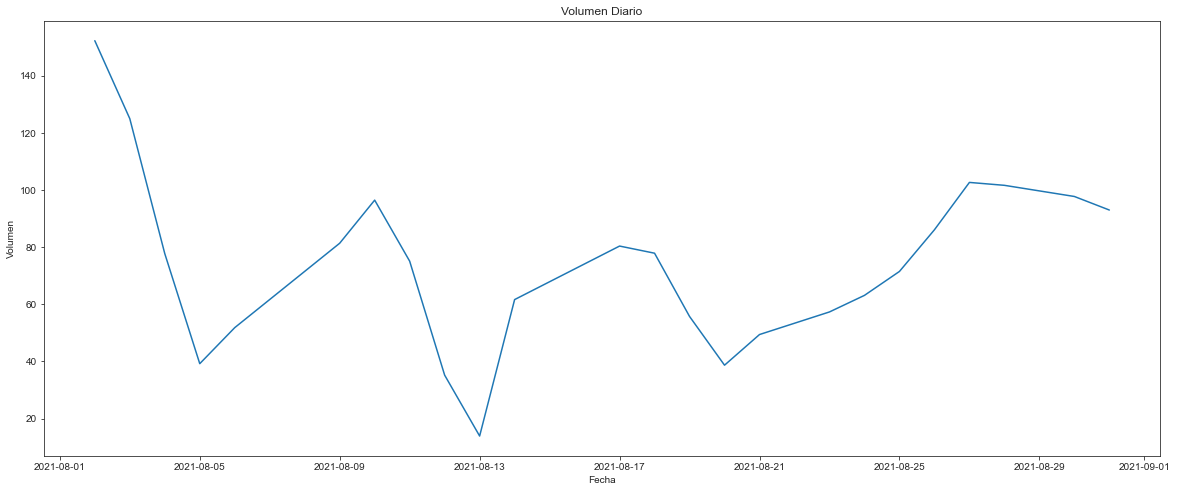

In [19]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
rotation = 45
sns.lineplot(x = df_result['FechaEntrega'], y = df_result['Forecast'])
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.title("Volumen Diario")
plt.show()